# Maching Learning Project: LSTM Stock Trend Prediction
## This project aims to create a deep learning model to predict the stock trend by adopting a classic method- LSTM (Long Short Term Memory).
## We'll be answering the following questions along the way:

1.  What attribute will be an ideal candidate to predict the trend of the stock market?
2.  Can we build up a LSTM model to predict a short-term trend of the stocks, such as 10 days?
3. How to implement our customized LSTM model by training our own data?



In [ ]:
# Install libraries for Google Collab
%pip install -q yfinance tensorflow mplfinance

# Install libraries for JupyterLab
#%pip install -q yfinance tensorflow mplfinance pandas_datareader dictionary datetime matplotlib scikit-learn

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplfinance as mpf          # require matplotlib and pandas to plot financial data

## 1. Data Loading Module
### This module is dedicated to download market data from [Yahoo!Finace's API](https://pypi.org/project/yfinance/).

In [ ]:
# from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()

# Set up the stocks, start and end times for data download.
stocks = ['NVDA', 'TSLA', 'AAPL', 'GOOG', 'MSFT']
end = datetime.now()
start = end - timedelta(days=60)    # delta: 60 days (max)

trends = {}

for stock in stocks:
  trends[stock] = pdr.get_data_yahoo(stock, start=start, end=end, interval="15m")    # interval: 15m

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
trends['MSFT']
#trends['NVDA'].describe()
#trends['NVDA'].info()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-02-29 09:30:00,408.614990,409.059998,407.739990,408.410004,408.410004,1779076
2024-02-29 09:45:00,408.415009,410.204987,408.223999,409.809998,409.809998,1181458
2024-02-29 10:00:00,409.809998,410.119995,408.339996,408.554993,408.554993,749303
2024-02-29 10:15:00,408.529999,408.999908,407.850006,408.329987,408.329987,718403
2024-02-29 10:30:00,408.359985,408.820007,407.695007,407.940002,407.940002,452022
...,...,...,...,...,...,...
2024-04-26 14:45:00,408.672302,409.149994,408.269989,409.040009,409.040009,450867
2024-04-26 15:00:00,409.049988,409.190002,408.665009,409.089996,409.089996,508620
2024-04-26 15:15:00,409.079987,409.690002,409.019989,409.609985,409.609985,548003


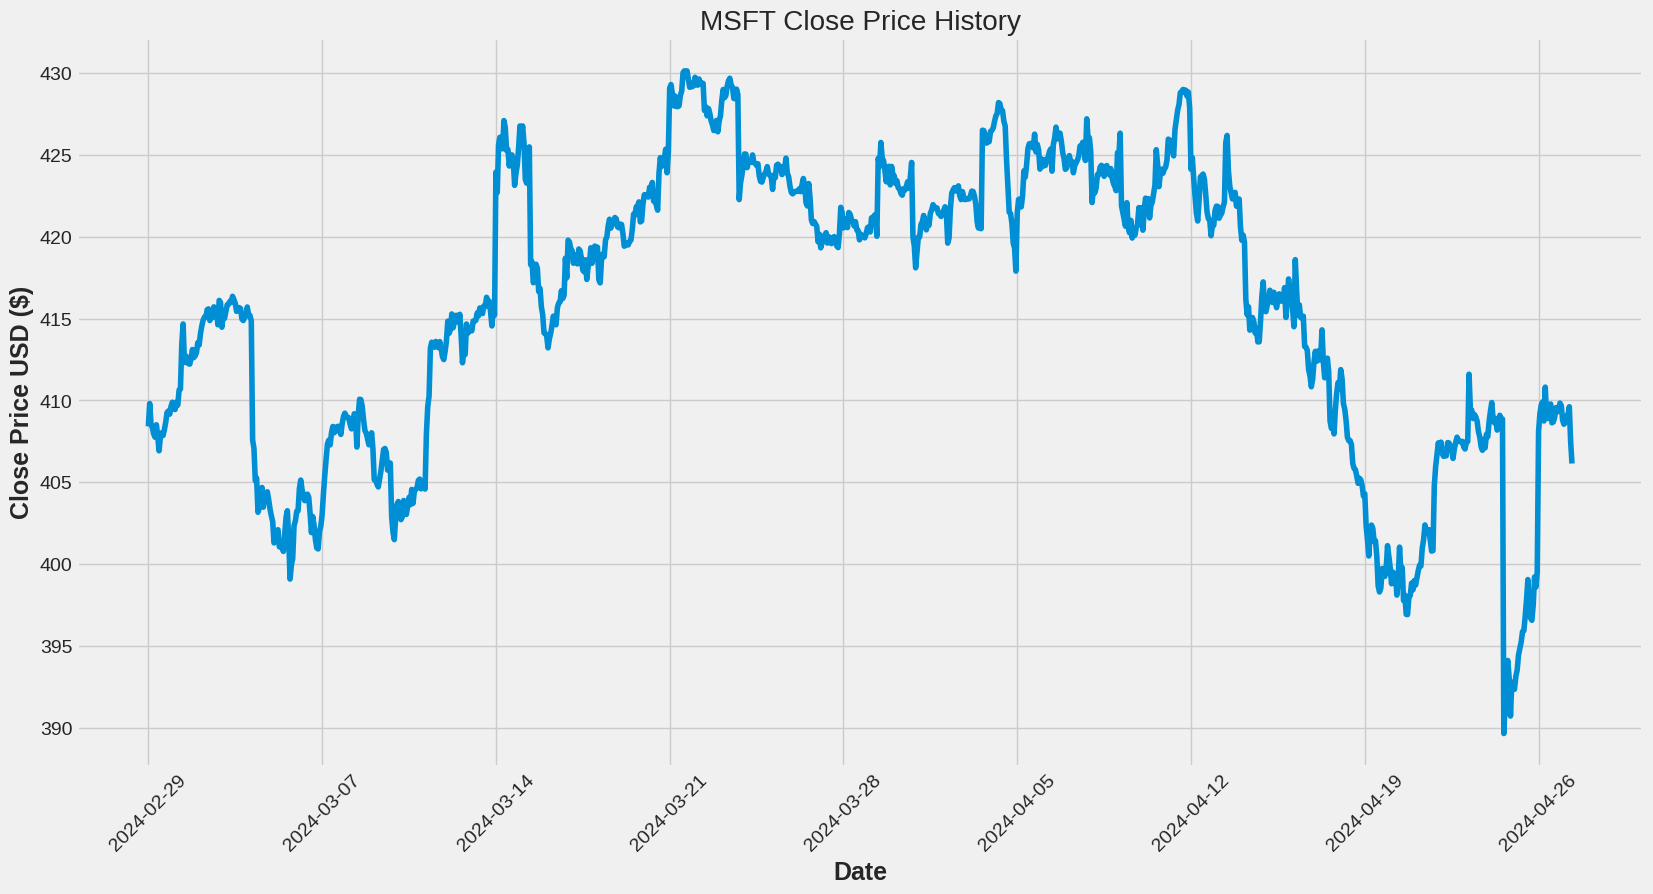

In [ ]:
# Select the stock to train the model
stock = 'MSFT'
df = trends[stock]

# Plot the stock price graph
plt.figure(figsize=(18,9))
plt.title(stock + ' Close Price History')
plt.plot(range(df.index.size), df['Close'])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

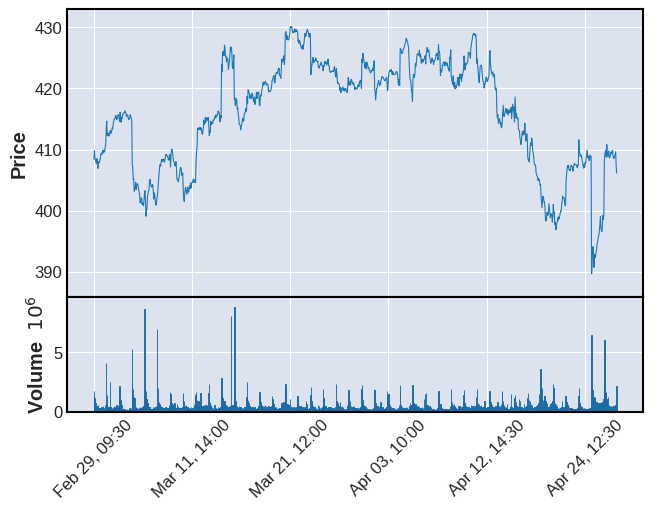

In [ ]:
# Used to compare chart
mpf.plot(df, type='line', volume=True)

In [ ]:
# @title Not used
'''
# Create figure and matplotlib plots with some additional formatting
fig, (top, bot) = plt.subplots(2, 1, sharex=True, figsize=(10,5),
                               gridspec_kw=dict(height_ratios=[0.75,0.25]))
top.plot(range(df.index.size), df['Close'])
top.set_title(stock+' Closed Price History', pad=20, size=14, weight='semibold')
top.set_ylabel('Price', labelpad=10)
top.grid(axis='x', alpha=0.3)
bot.bar(range(df.index.size), df['Volume'], width=1)
bot.set_ylabel('Volume', labelpad=10)

# Set fixed major and minor tick locations
ticks_date = df.index.indexer_at_time('09:30')[::-5]    # step in days
bot.set_xticks(ticks_date)

# Format major and minor tick labels
labels_date = [maj_tick.strftime('\n%d-%b').replace('\n0', '\n')
               for maj_tick in df.index[ticks_date]]

bot.set_xticklabels(labels_date)
bot.figure.autofmt_xdate(rotation=0, ha='center', which='both')
'''
pass

# 2. Data Prepocess Module

In [ ]:
# Used to normalize the data
from sklearn.preprocessing import MinMaxScaler

# Used to standardize the data (Not used)
# from sklearn.preprocessing import StandardScaler

# Used for data padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
raw_data = df.filter(['Close'])

dataset = raw_data.copy().to_numpy()

train_data_n = int(len(dataset)*0.8)
test_data_n = len(dataset) - train_data_n

train_data_n, test_data_n, len(dataset)

(852, 214, 1066)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# print(scaled_data)

In [ ]:
# Training Set & Validation Set Preprocess
train_data = scaled_data[0:train_data_n, :]

x_train = []
y_train = []

# Choose the size of predictors
sequence_size = 60

for i in range(sequence_size, train_data_n):
  x_train.append(train_data[i-sequence_size:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(792, 60, 1)

## 2 Different Approaches on Constructing Testing Set

In [ ]:
# Testing Set Preprocess (Stock Price Predictor)
# Used actual prices in all the predictors.
# Best for predicting stock price.
# Pros: High Accuracy
# Cons: Can predict 1 step ahead only. (In our case, 15 minutes ahead)

test_data1 = scaled_data[train_data_n - 60: , :]

x_test1 = []
y_test1 = dataset[train_data_n: , :]

for i in range(sequence_size, len(test_data1)):
  x_test1.append(test_data1[i-60:i, 0])

x_test1 = np.array(x_test1)

x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1 ))
x_test1.shape

(214, 60, 1)

In [ ]:
# Testing Set Preprocess (Stock Trend Predictor)
# Used combination of actual price and predicted price as predictors.
# Best for predicting stock trends.
# Pros: Can predict few steps ahead.
# Cons: Accuracy getting worse after a few predictions.
test_data2 = scaled_data[train_data_n - 60: train_data_n, :]

x_test2 = []
y_test2 = dataset[train_data_n: , :]

for i in range(0, sequence_size):
  partial_sequence = test_data2[i:sequence_size, 0]
  x_test2.append(partial_sequence)

for i in range(sequence_size, test_data_n):
  x_test2.append([0])

x_test2 = np.array(pad_sequences(x_test2, maxlen=sequence_size, padding='post', dtype='float32'))

x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 1 ))
x_test2.shape, y_test2.shape

((214, 60, 1), (214, 1))

#3. Data Training Module

In [ ]:
# From Nvidia lab 6
from keras.preprocessing.sequence import pad_sequences
# from keras import utils

# Embedding and dropout used in nvidia.
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))    # Multi-layer LSTM
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_12 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 1)                

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=15)

Epoch 1/15
792/792 [==============================] - 12s 11ms/step - loss: 0.0086
Epoch 2/15
792/792 [==============================] - 13s 17ms/step - loss: 0.0042
Epoch 3/15
792/792 [==============================] - 12s 15ms/step - loss: 0.0029
Epoch 4/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0023
Epoch 5/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0019
Epoch 6/15
792/792 [==============================] - 7s 8ms/step - loss: 0.0019
Epoch 7/15
792/792 [==============================] - 7s 8ms/step - loss: 0.0016
Epoch 8/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0015
Epoch 9/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0014
Epoch 10/15
792/792 [==============================] - 8s 9ms/step - loss: 0.0016
Epoch 11/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0014
Epoch 12/15
792/792 [==============================] - 7s 9ms/step - loss: 0.0013
Epoch 13/15
792/792

# 4. Prediction Module

## Stock Price Predictor

In [ ]:
predictions = model.predict(x_test1)
#print(predictions.size)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test1) ** 2)))
rmse

7/7 [==============================] - 1s 5ms/step


3.292897938092658

                          Close  Predictions
Datetime                                    
2024-04-16 14:30:00  416.059998   415.096008
2024-04-16 14:45:00  417.420013   415.732910
2024-04-16 15:00:00  416.404999   417.089905
2024-04-16 15:15:00  416.980011   416.339264
2024-04-16 15:30:00  415.573212   416.669678
...                         ...          ...
2024-04-26 14:45:00  409.040009   408.902832
2024-04-26 15:00:00  409.089996   409.345367
2024-04-26 15:15:00  409.609985   409.469574
2024-04-26 15:30:00  407.468689   409.951233
2024-04-26 15:45:00  406.140015   407.986481

[214 rows x 2 columns]


<ipython-input-144-ba490cf04b50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


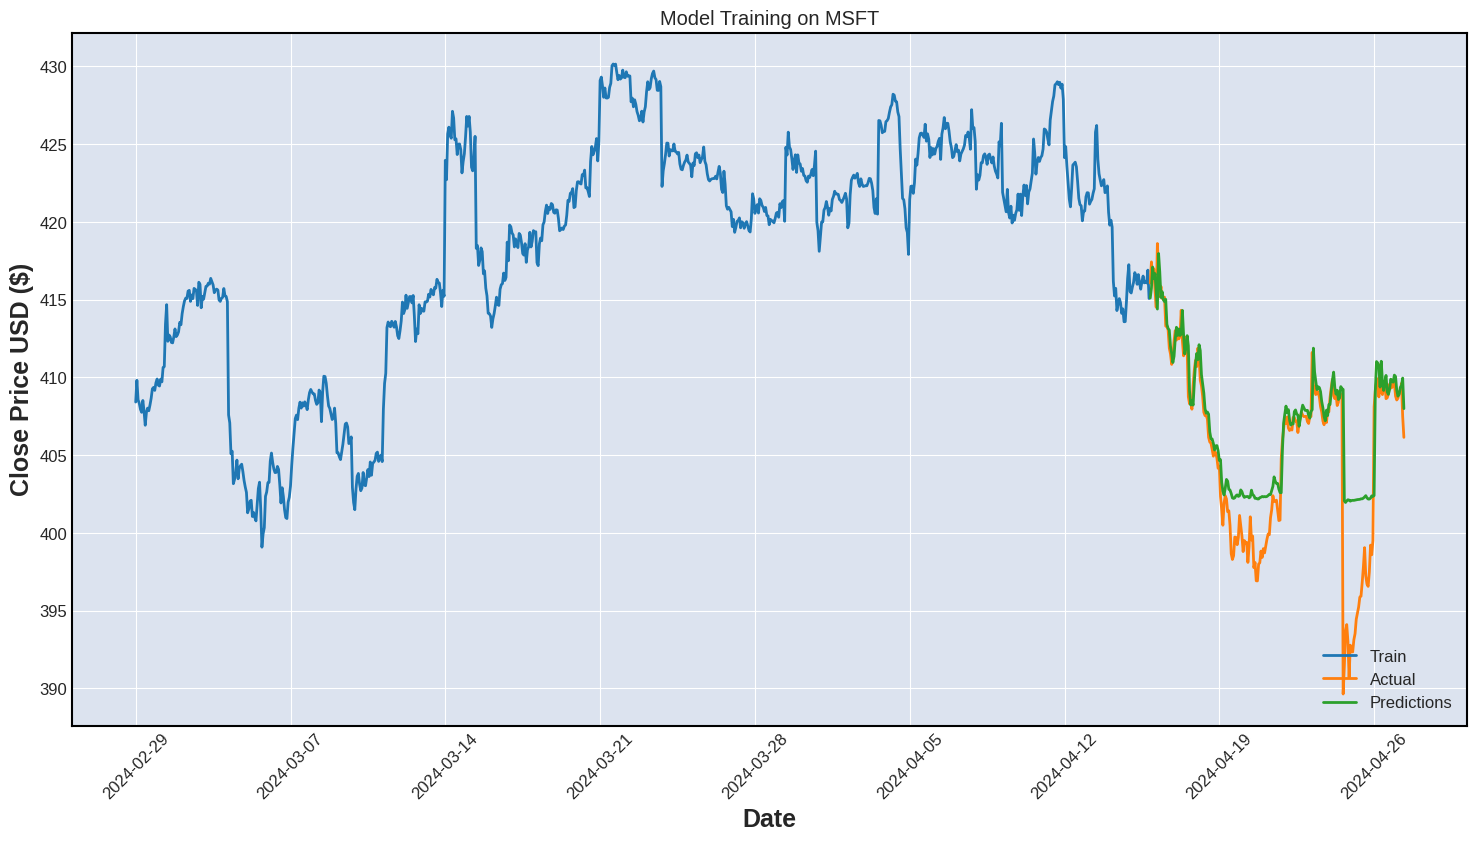

In [ ]:
train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

print(valid)

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

## Stock Trend Predictor

In [ ]:
predictions_list = []

for i in range(0, test_data_n):
  single_test = np.reshape(x_test2[i], (1, x_test2.shape[1], 1))

  prediction = model.predict(single_test)

  predictions_list.append(prediction[0])

  if (test_data_n - i <= sequence_size and test_data_n - i > 0):
    for j, k in zip(range(i+1, test_data_n), range(sequence_size-1, sequence_size-test_data_n+i, -1)): #sequence_size
      x_test2[j, k] = prediction
  else:
    for j in range(i+1, i+sequence_size+1):
      x_test2[j, -j+i] = prediction


np_predictions = np.array(predictions_list)

predictions = scaler.inverse_transform(np_predictions)

rmse = np.sqrt(np.mean(((predictions - y_test2) ** 2)))
rmse

1/1 [==============================] - 0s 20ms/step


10.711821057797065

                          Close  Predictions
Datetime                                    
2024-04-16 14:30:00  416.059998   415.096008
2024-04-16 14:45:00  417.420013   414.878815
2024-04-16 15:00:00  416.404999   414.744568
2024-04-16 15:15:00  416.980011   414.643219
2024-04-16 15:30:00  415.573212   414.564423
...                         ...          ...
2024-04-26 14:45:00  409.040009   414.226410
2024-04-26 15:00:00  409.089996   414.226410
2024-04-26 15:15:00  409.609985   414.226410
2024-04-26 15:30:00  407.468689   414.226410
2024-04-26 15:45:00  406.140015   414.226410

[214 rows x 2 columns]


<ipython-input-146-ba490cf04b50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


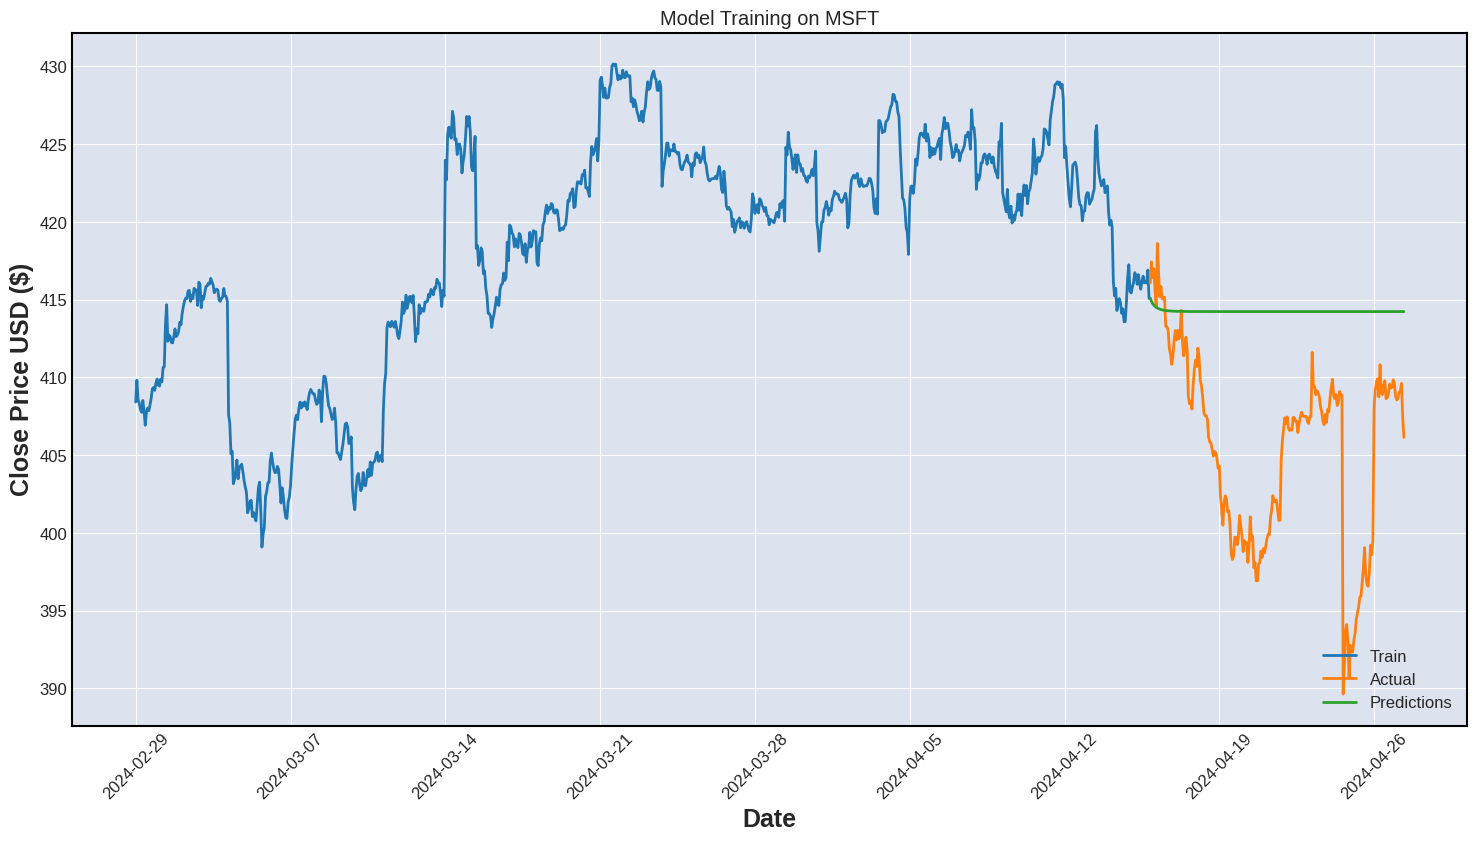

In [ ]:
train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

print(valid)

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

7/7 [==============================] - 0s 5ms/step
3.292897938092658


<ipython-input-147-7623e49867e7>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


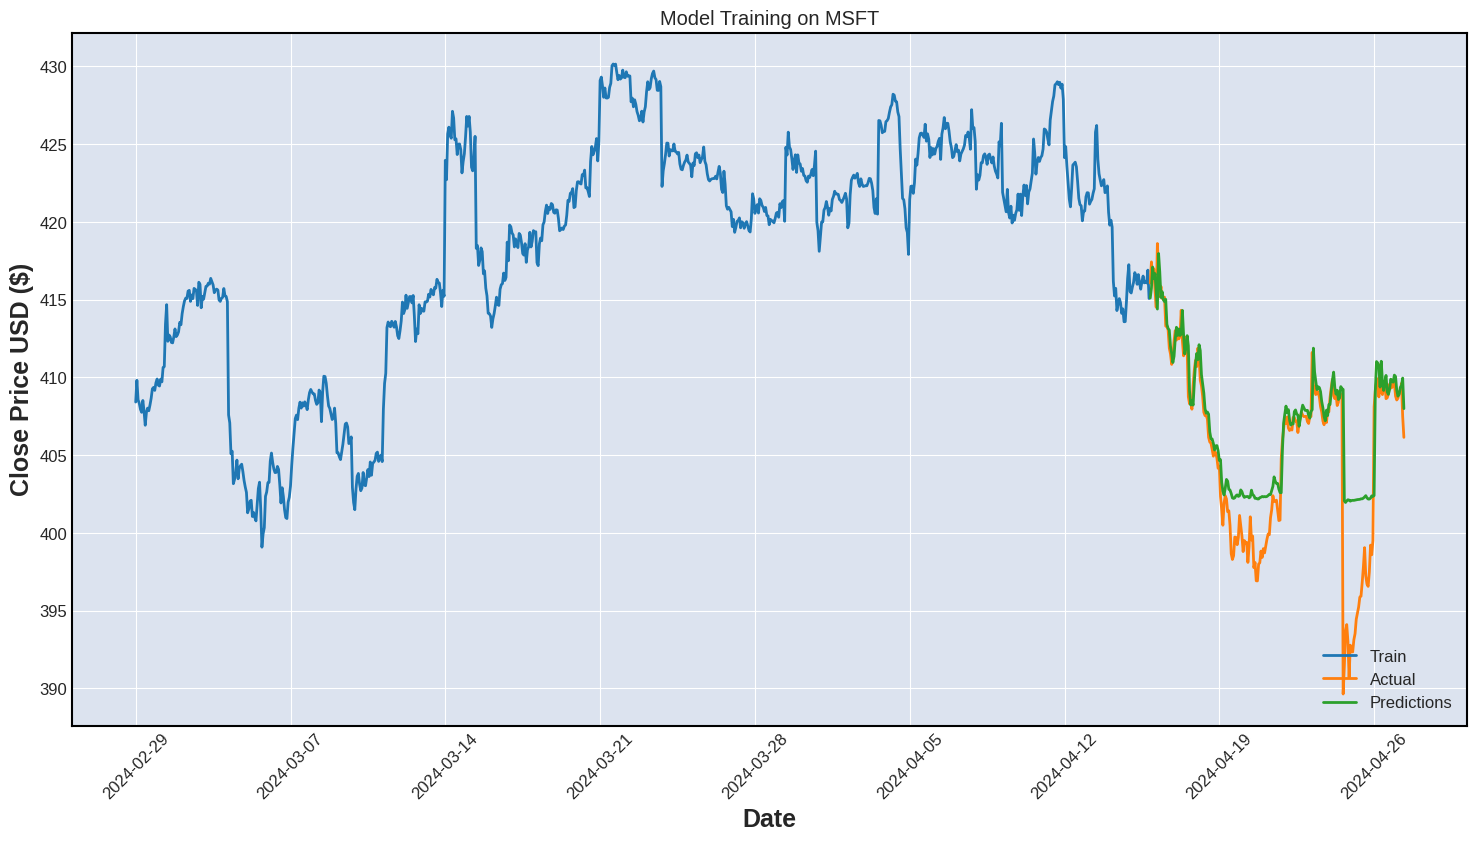

In [ ]:
# @title Cross reference with other stock market
stock = 'MSFT'
df = trends[stock]

raw_data = df.filter(['Close'])
dataset = raw_data.values
train_data_n = int(len(dataset)*0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



# Testing Set Preprocess
test_data = scaled_data[train_data_n - 60: , :]

x_test = []
y_test = dataset[train_data_n: , :]

for i in range(sequence_size, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))




# Prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)




train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(18,9))
plt.title('Model Training on ' + stock)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()